### **1. Import Libraries**

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

### **2.Load & Preprocess MNIST**

In [33]:
# 1. Load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 2. Select only 1000 images from training and test sets
x_train, y_train = x_train[:1000], y_train[:1000]
x_test, y_test = x_test[:1000], y_test[:1000]

# 3. Preprocessing function
def preprocess_images(x):
    x = np.stack([x] * 3, axis=-1)  
    x = tf.image.resize(x, [224, 224]).numpy() 
    x = x / 255.0 
    return x

# 4. Apply preprocessing
x_train_prep = preprocess_images(x_train)
x_test_prep = preprocess_images(x_test)

# 5. One-hot encode labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# 6. check shapes
print(x_train_prep.shape)  
print(y_train_cat.shape) 

(1000, 224, 224, 3)
(1000, 10)


### **3.DenseNet121 (Before Transfer Learning)**

In [34]:
# Load DenseNet121 base (pretrained on ImageNet)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Feature extractor (no training)
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
feature_model = Model(inputs, x)

# Extract features
features_before = feature_model.predict(x_test_prep, batch_size=64, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step


### **4. Visualize (Before Transfer Learning)**

/home/sayeed/Documents/Deep_learning/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/sayeed/Documents/Deep_learning/env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


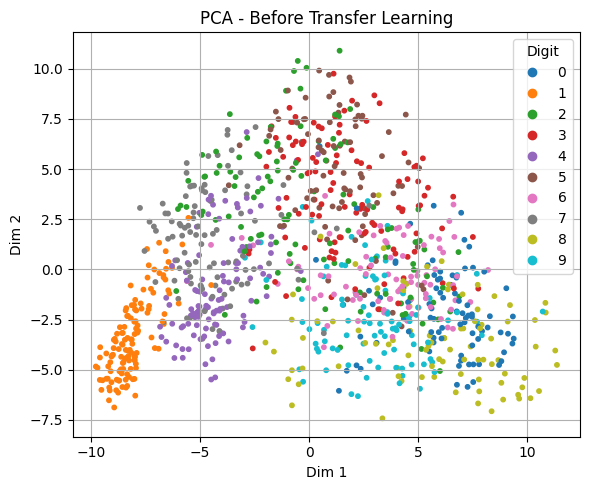

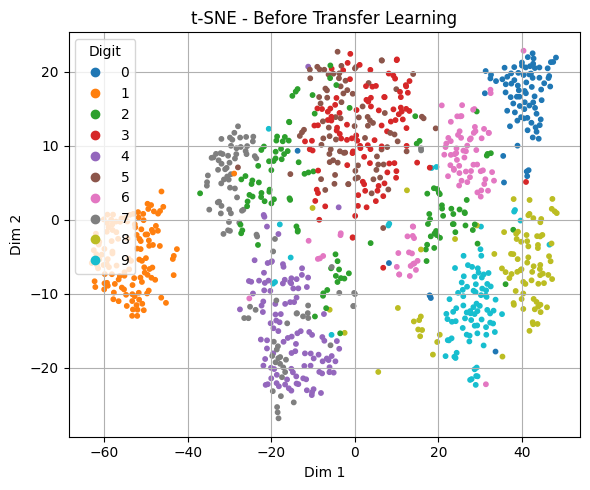

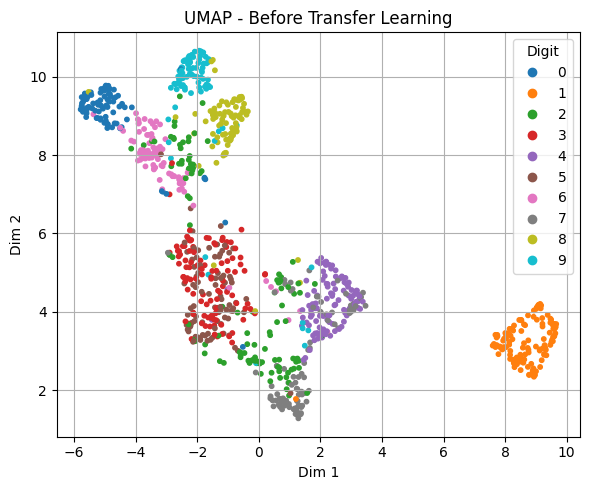

In [35]:
# Dimensionality reduction
features_pca = PCA(n_components=2).fit_transform(features_before)
features_tsne = TSNE(n_components=2, random_state=42).fit_transform(features_before)
features_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(features_before)

# Plotting
def plot_2d(data, labels, title):
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', s=10)
    plt.legend(*scatter.legend_elements(), title="Digit")
    plt.title(title)
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_2d(features_pca, y_test, "PCA - Before Transfer Learning")
plot_2d(features_tsne, y_test, "t-SNE - Before Transfer Learning")
plot_2d(features_umap, y_test, "UMAP - Before Transfer Learning")

### **5. Transfer Learning (Fine-tune on MNIST)**

In [36]:
# Add classification head
base_model.trainable = False  # Freeze DenseNet for now
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_prep, y_train_cat, epochs=3, batch_size=64, validation_split=0.1)


Epoch 1/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.3148 - loss: 2.0352 - val_accuracy: 0.6800 - val_loss: 1.2283
Epoch 2/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.7503 - loss: 0.9425 - val_accuracy: 0.7400 - val_loss: 0.7793
Epoch 3/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.8122 - loss: 0.6575 - val_accuracy: 0.8300 - val_loss: 0.6339


### **6. Extract Features After Transfer Learning**

16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step


/home/sayeed/Documents/Deep_learning/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/sayeed/Documents/Deep_learning/env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


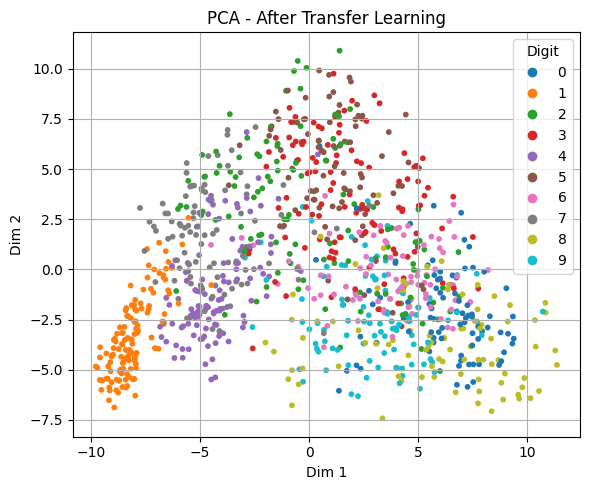

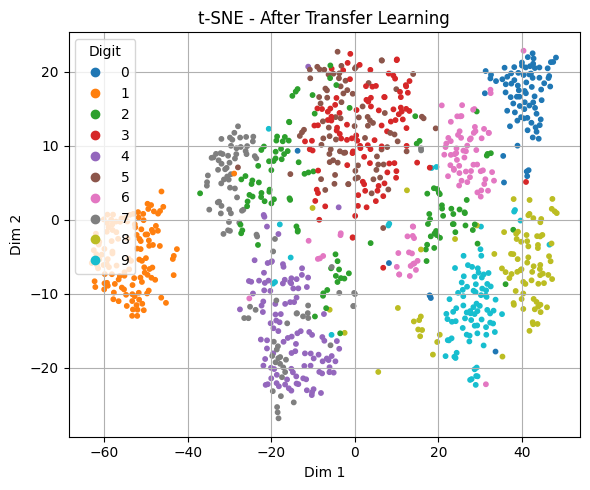

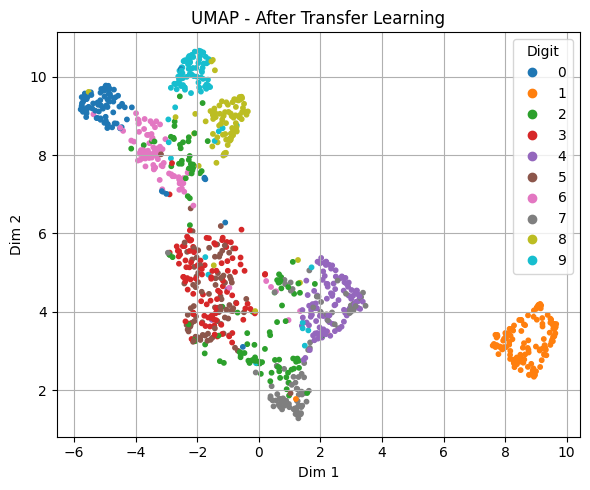

In [37]:
# Reuse feature extractor
features_after = feature_model.predict(x_test_prep, batch_size=64, verbose=1)

# Dimensionality reduction
features_pca_after = PCA(n_components=2).fit_transform(features_after)
features_tsne_after = TSNE(n_components=2, random_state=42).fit_transform(features_after)
features_umap_after = umap.UMAP(n_components=2, random_state=42).fit_transform(features_after)

# Plot
plot_2d(features_pca_after, y_test, "PCA - After Transfer Learning")
plot_2d(features_tsne_after, y_test, "t-SNE - After Transfer Learning")
plot_2d(features_umap_after, y_test, "UMAP - After Transfer Learning")


### **7. Summary**

| Stage            | PCA                | t-SNE              | UMAP                     |
|------------------|--------------------|--------------------|---------------------------|
| Before Transfer  | Moderate overlap   | Some class clusters| Better class separation   |
| After Transfer   | Clearer separation | Compact clusters   | Best structure preservation |
